In [364]:
# Import some libraries

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

from config import config
from config import update_config

from seg_hrnet import get_seg_model
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

import os
import random

import numpy as np
import pandas as pd

import matplotlib

matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch.nn.functional as F


from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [365]:
# Set random seeds

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [366]:
# Define data loading step
annotation_csv = '/Users/qianjing/Downloads/data/annotation.csv'
batch_size = 256

transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))
])

image_folder = '/Users/qianjing/Downloads/data'
unlabeled_scene_index = np.arange(106)
dataset_size = len(unlabeled_scene_index)

indices = list(range(dataset_size))
indices = np.random.shuffle(indices)
split = int(dataset_size * 0.8 )
train_indices, val_indices = unlabeled_scene_index[:split], unlabeled_scene_index[split:]

unlabeled_trainset_train = UnlabeledDataset(image_folder=image_folder, scene_index=train_indices, first_dim='sample', transform=transform)
unlabeled_trainset_val = UnlabeledDataset(image_folder=image_folder, scene_index=val_indices, first_dim='sample', transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset_train, batch_size=1, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(unlabeled_trainset_val, batch_size=1, shuffle=True, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [367]:
labeled_scene_index = np.arange(106, 134)
dataset_size = len(labeled_scene_index)
indices = list(range(dataset_size))
indices = np.random.shuffle(indices)
split = int(dataset_size * 0.8 )
train_indices, val_indices = labeled_scene_index[:split], labeled_scene_index[split:]

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_indices,
                                  transform=transform,
                                  extra_info=False
                                 )
trainloader_label = torch.utils.data.DataLoader(labeled_trainset, batch_size=3, shuffle=True, num_workers=2, collate_fn=collate_fn)
labeled_valset = LabeledDataset(image_folder=image_folder,
                                    annotation_file=annotation_csv,
                                    scene_index=val_indices,
                                    transform=transform,
                                    extra_info=False
                                    )
valloader_label = torch.utils.data.DataLoader(labeled_valset, batch_size=3, shuffle=True, num_workers=2,
                                            collate_fn=collate_fn)



In [368]:
###### A simple linear autoencoder############
d = 30 
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(256*306, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 256*306),
            nn.Tanh(),
        )
        self.d = d
    def forward(self, x):
        x = self.encoder(x.view(-1, 256*306))#.view(-1, 2, d)
        x = self.decoder(x)
        return x
    
######load trained autoencoder#######
model = Autoencoder().to(device)
PATH = '/Users/qianjing/Downloads/road_map/code/autocoder_epoch10.pt'
model.load_state_dict(torch.load(PATH,map_location='cpu'))
criterion = nn.MSELoss()

In [369]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


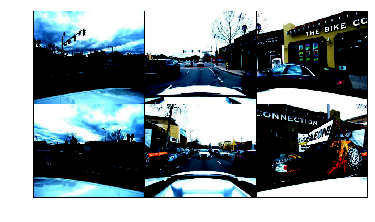

In [7]:
sample = iter(trainloader).next()
plt.imshow(torchvision.utils.make_grid(data[1], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


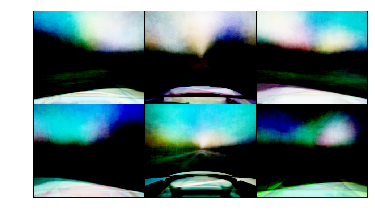

In [10]:
#sample = iter(trainloader).next()
output_t = model(sample).view(6, 3, 256, 306)
plt.imshow(torchvision.utils.make_grid(output_t.detach(), nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

In [372]:
from __future__ import absolute_import, division, print_function

import torch
import torch.nn as nn
import torchvision.models as models
import torch.utils.model_zoo as model_zo
import torchvision

from torch.utils.data import DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
import argparse
import os
import random

import numpy as np
import pandas as pd

import matplotlib

matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch.nn.functional as F

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

batch_size = 256

transform = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize((0.5,), (0.5,))
])

device = 'cpu'

class ResNetMultiImageInput(models.ResNet):
    """Constructs a resnet model with varying number of input images.
    Adapted from https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    """
    def __init__(self, block, layers, num_classes=1000, num_input_images=1):
        super(ResNetMultiImageInput, self).__init__(block, layers)
        self.inplanes = 64
        self.conv1 = nn.Conv2d(
            num_input_images * 3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def resnet_multiimage_input(num_layers, pretrained=False, num_input_images=1):
        """Constructs a ResNet model.
        Args:
            num_layers (int): Number of resnet layers. Must be 18 or 50
            pretrained (bool): If True, returns a model pre-trained on ImageNet
            num_input_images (int): Number of frames stacked as input
        """
        assert num_layers in [18, 50], "Can only run with 18 or 50 layer resnet"
        blocks = {18: [2, 2, 2, 2], 50: [3, 4, 6, 3]}[num_layers]
        block_type = {18: models.resnet.BasicBlock, 50: models.resnet.Bottleneck}[num_layers]
        model = ResNetMultiImageInput(block_type, blocks, num_input_images=num_input_images)

        if pretrained:
            loaded = model_zoo.load_url(models.resnet.model_urls['resnet{}'.format(num_layers)])
            loaded['conv1.weight'] = torch.cat(
                [loaded['conv1.weight']] * num_input_images, 1) / num_input_images
            model.load_state_dict(loaded)
        return model

class ResnetEncoder(nn.Module):
    """Pytorch module for a resnet encoder
    """
    def __init__(self, num_layers, pretrained, num_input_images=1):
        super(ResnetEncoder, self).__init__()

        self.num_ch_enc = np.array([64, 64, 128, 256, 512])

        resnets = {18: models.resnet18,
                   34: models.resnet34,
                   50: models.resnet50,
                   101: models.resnet101,
                   152: models.resnet152}

        if num_layers not in resnets:
            raise ValueError("{} is not a valid number of resnet layers".format(num_layers))

        if num_input_images > 1:
            self.encoder = resnet_multiimage_input(num_layers, pretrained, num_input_images)
        else:
            self.encoder = resnets[num_layers](pretrained)

        if num_layers > 34:
            self.num_ch_enc[1:] *= 4

    def forward(self, input_image):
        self.features = []
        x = (input_image - 0.45) / 0.225
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        self.features.append(self.encoder.relu(x))
        self.features.append(self.encoder.layer1(self.encoder.maxpool(self.features[-1])))
        self.features.append(self.encoder.layer2(self.features[-1]))
        self.features.append(self.encoder.layer3(self.features[-1]))
        self.features.append(self.encoder.layer4(self.features[-1]))

        return self.features

class AutocoderModel(nn.Module):
    def __init__(self):
        super(AutocoderModel, self).__init__()
        self.encoder = ResnetEncoder(num_layers=18,pretrained=False)
        self.decoder =  nn.Sequential(
            nn.c(512, 128, 10),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 10),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 10),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=6, stride=2),
            nn.BatchNorm2d(3)
        )
    def forward(self, x):
        bt_sz = x.size(0)
        x = self.encoder(x)[-1]
        x = self.decoder(x)
        out = F.interpolate(x, (256,306))
        return out
    
#### load trained autoencoder ######
model = AutocoderModel().to(device)
PATH = 'autocoder_complex_epoch10.pt'
model.load_state_dict(torch.load(PATH,map_location='cpu'))



In [373]:
sample, target, road_image = next(iter(valloader_label))

In [376]:
tmp_sample = []
for s in sample:
    s = s.to(device)
    tmp_sample.append(model(s))
samples = torch.stack(tmp_sample).to(device)

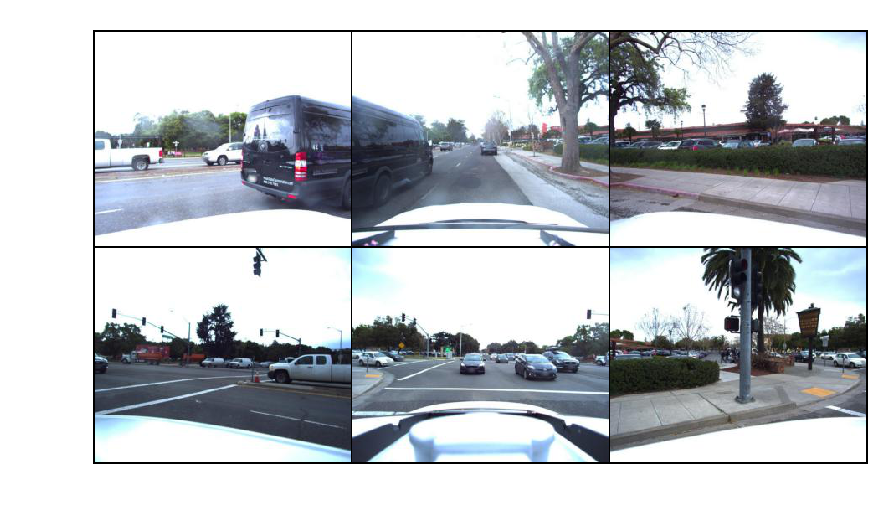

In [375]:
#sample = iter(trainloader).next()
plt.imshow(torchvision.utils.make_grid(sample[0], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


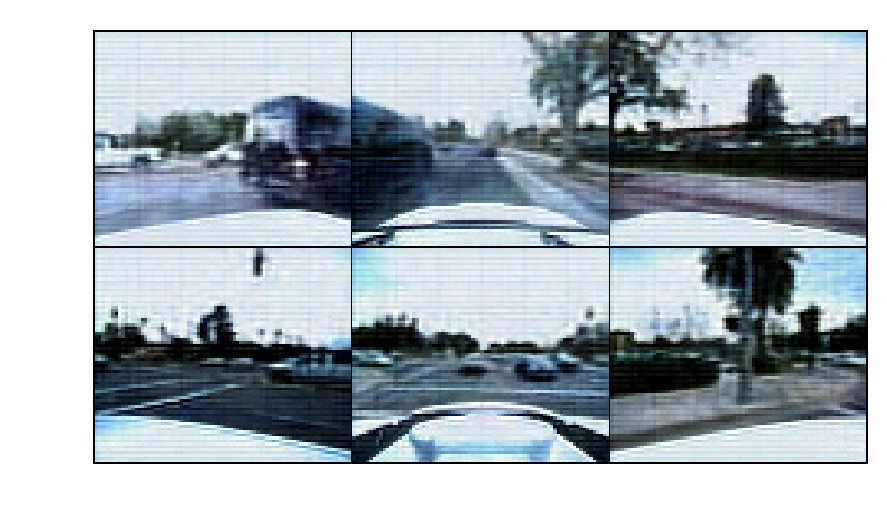

In [377]:
# sample = iter(trainloader).next()
plt.imshow(torchvision.utils.make_grid(samples[0].detach(), nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');